# Towards Data Science Blog Posts: Jargon Analysis
## Regression  
### *Attempt to model the relationship between the proportion and frequency of jargon words with the target variable: claps.* 

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

import re
from nltk.tokenize import WhitespaceTokenizer

import warnings
warnings.filterwarnings('ignore')

In [88]:
filename =  '../data/tds_vectorized_jargon.csv'

In [89]:
df = pd.read_csv(filename)

In [90]:
df.head()

,claps,text,A/B testing,accuracy,action,activation function,active learning,AdaGrad,agent,agglomerative clustering,...,user matrix,validation,validation set,vanishing gradient problem,Wasserstein loss,weight,Weighted Alternating Least Squares (WALS),wide model,width,total_jargon_count
0,489,ultimate guide acing coding interviews data sc...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
1,139,shakespeare versus eminem— who’s better lyrici...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,8
2,133,implementing visualttransformer pytorch hi guy...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,42
3,92,stock price analysis pandas altair practical g...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
4,58,optimal threshold imbalanced classification ha...,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,145


In [91]:
df.shape

(9290, 415)

In [63]:
X = df.drop(columns = ['claps', 'text'])
y = df['claps']

#### Look at Phrase Frequency in the Corpus

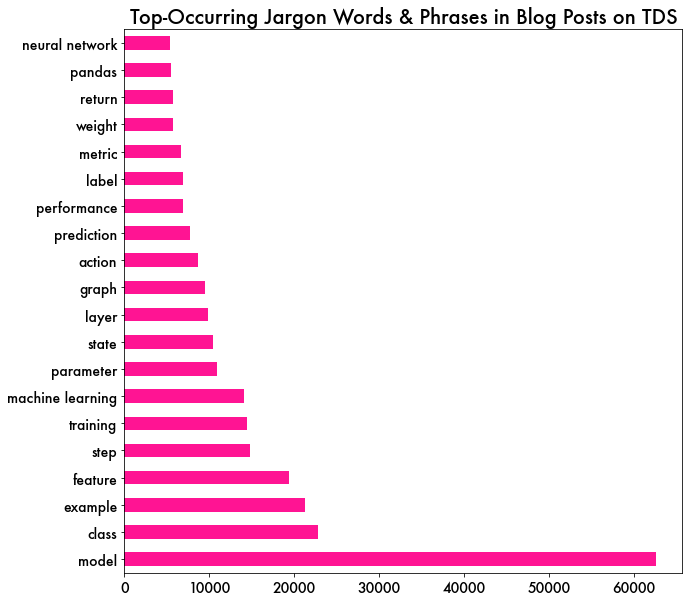

In [6]:
# plot top occurring words/phrases

#remove the total count for the plot
jargon_X = X.drop(columns='total_jargon_count')
plt.figure(figsize = (10,10))
jargon_X.sum().sort_values(ascending = False).head(20).plot(kind='barh', color='deeppink');
figurefont = {'fontname' : 'Futura'}
plt.xticks(**figurefont, fontsize = 14);
plt.yticks(**figurefont, fontsize = 14);
plt.title('Top-Occurring Jargon Words & Phrases in Blog Posts on TDS',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_top_occurring_jargon.jpg',  bbox_inches = "tight")

### Investigation I: Effect of Proportion of Jargon on Number of Claps

In [16]:
df['total_jargon_count'].head()

9010    18
4975    87
4002    13
7191    21
6827    43
Name: total_jargon_count, dtype: int64

In [44]:
#read in preprocessed abstracts to get total word count
tds = pd.read_csv('../data/tds_nltk_stemmed_preproc.csv').drop(columns = 'Unnamed: 0')

In [45]:
tds.shape

(9290, 5)

In [49]:
#get both dataframes in the same order
df = df.sort_values(by = ['claps', 'text'], ascending=False, ignore_index=True)
tds = tds.sort_values(by = ['claps', 'text'], ascending=False, ignore_index=True)

In [50]:
df.tail()

,claps,text,A/B testing,accuracy,action,activation function,active learning,AdaGrad,agent,agglomerative clustering,...,user matrix,validation,validation set,vanishing gradient problem,Wasserstein loss,weight,Weighted Alternating Least Squares (WALS),wide model,width,total_jargon_count
9285,0,artificial intelligence doesn’t exist (yet) mu...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39
9286,0,applications artificial intelligence fire & sa...,0,1,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,47
9287,0,alliterative affinities: parents select first ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,18
9288,0,advanced analytics coming heading let’s explor...,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33
9289,0,7 reasons work startup 1 reason find life mach...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [51]:
tds.tail()

,claps,len_paragraphs,len_title,days_live,text
9285,0,7369,47,124,artifici intellig doesn’t exist (yet) much pic...
9286,0,6427,56,147,applic artifici intellig fire & safeti overvie...
9287,0,6363,73,19,allit affinities: parent select first name mat...
9288,0,7472,70,73,advanc analyt come head let’ explor an… advanc...
9289,0,6784,51,38,7 reason work startup 1 reason find life machi...


In [52]:
#remove punctuation characters 
tds['text'] = tds['text'].replace("[''·,\.!?'-]",'',regex=True)
#remove brackets surrounding the text
tds['text'] = tds['text'].map(lambda x: x.replace("[",""))
tds['text'] = tds['text'].map(lambda x: x.replace("]",""))

In [53]:
#tokenize text into lists to get word count
w_tokenizer = WhitespaceTokenizer()
tds['text'] = tds['text'].apply(lambda x: w_tokenizer.tokenize(x))

In [57]:
# calculate word count, jargon count, and jargon proportion 
word_count = tds['text'].apply(lambda x: len(x))
jargon_count = df['total_jargon_count']

jargon_prop = (jargon_count/word_count)

In [58]:
#Create new dataframe with jargon prop and citations
prop = pd.DataFrame()
prop['jargon_prop'] = pd.Series(jargon_prop)
prop['claps'] = df['claps']

In [59]:
# calculate correlation|
stats.pearsonr(prop['claps'],prop['jargon_prop'])

(-0.023064463501394718, 0.026211976143278377)

Once again, confirming that the proportion of machine learning jargon is not correlated with the number of claps.

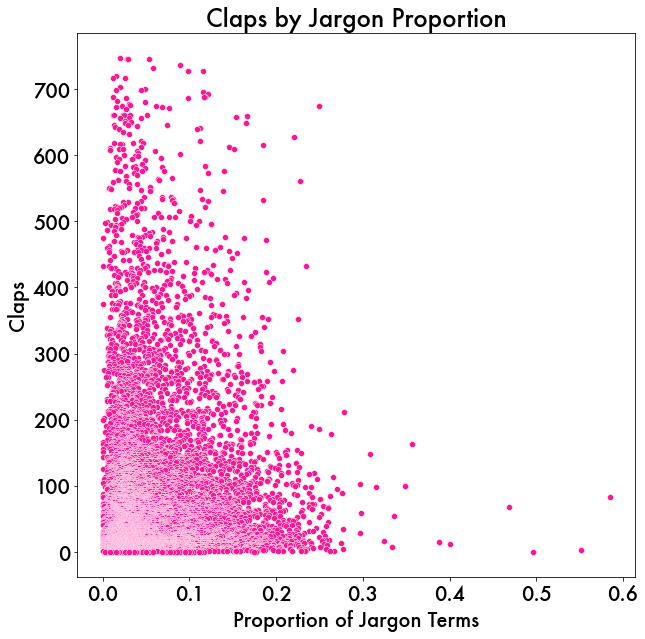

In [60]:
plt.figure(figsize = (10, 10));
sns.scatterplot(data=prop, x='jargon_prop', y='claps', color ='deeppink');
figurefont = {'fontname' : 'Futura'};
plt.title('Claps by Jargon Proportion', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Proportion of Jargon Terms',**figurefont, fontsize = 20);
plt.ylabel('Claps',**figurefont, fontsize = 20);
plt.savefig('../figures/tds_claps_jargon_prop_scatterplot.jpg',  bbox_inches = "tight")

Let's see if the regression analysis for proportion bears any fruit. 

In [65]:
X = prop[['jargon_prop']]
y = prop['claps']

In [66]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 random_state=42)

In [67]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [68]:
train_score = linreg.score(X_train, y_train)
test_score = linreg.score(X_test, y_test)
cv_score = cross_val_score(linreg, X_train, y_train).mean()
print(train_score, test_score, cv_score)

0.0008435792702319311 -0.0011493196698186825 -0.00033328374049335086


Proportion of jargon does not account for practically any variance in claps.

### Investigation II: Effect of Quantity of Jargon on Number of Claps

In [84]:
stats.pearsonr(df['claps'],df['total_jargon_count'] )

(0.01926105362477824, 0.06339767253483564)

Once again, given the lack of correlation between the total jargon count and the target variable, I will see if any of the specific jargon terms (collectively or separately) account for some of the variance in the number of claps.

In [73]:
X = df.drop(columns = ['claps', 'text'])
y = df['claps']

In [74]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 random_state=42)

In [79]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [80]:
linreg = LinearRegression()
linreg.fit(Z_train, y_train)

LinearRegression()

In [81]:
train_score = linreg.score(Z_train, y_train)
test_score = linreg.score(Z_test, y_test)
cv_score = cross_val_score(linreg, Z_train, y_train).mean()
print(train_score, test_score, cv_score)

0.041761619925698934 -3.0601543523554085e+23 -6.1367277731176555e+26


Only 0.04 R2 for the training data - it appears that none of these jargon terms are predictive of the number of citations; will try regularization, as it's still overfit at 0.04! 

In [83]:
# Set up a list of Lasso alphas to check.
l_alphas = np.linspace(-3,0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=5_000)

# Fit model using best lasso alpha!
lasso_cv.fit(Z_train, y_train)

train_score = lasso_cv.score(Z_train, y_train)
test_score = lasso_cv.score(Z_test, y_test)
cv_score = cross_val_score(lasso_cv, Z_train, y_train).mean()
print(train_score, test_score, cv_score)

0.05092213833887527 -0.08273275204857633 -53145999.733503506


In [86]:
model_list = [
    LinearRegression(),
    DecisionTreeRegressor(),
    BaggingRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    SVR(),
]

results_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj
   
    #fit the model
    model.fit(X_train, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(Z_train, y_train)
    results_dict['test_score'] = model.score(Z_test, y_test)
    results_dict['cv_score'] = cross_val_score(model, Z_train, y_train, cv = 5).mean()
    results_dict['train_RMSE'] = np.sqrt(mean_squared_error(y_train, model.predict(Z_train)))
    results_dict['test_RMSE'] = np.sqrt(mean_squared_error(y_test, model.predict(Z_test))) 
    
    #add the dictionary to the list
    results_list.append(results_dict)

In [87]:
results = pd.DataFrame(results_list)
results

,model_name,train_score,test_score,cv_score,train_RMSE,test_RMSE
0,LinearRegression(),-4.408988e+20,-8.950200e+20,-6.136728e+26,2.413367e+12,3.605724e+12
1,DecisionTreeRegressor(),-6.284440e-01,-5.761690e-01,-9.094337e-01,1.466697e+02,1.513134e+02
2,BaggingRegressor(),-1.835273e-01,-1.965247e-01,-1.076528e-01,1.250383e+02,1.318369e+02
3,RandomForestRegressor(),-1.202399e-01,-1.558310e-01,-3.474984e-02,1.216493e+02,1.295756e+02
4,AdaBoostRegressor(),-3.613123e-01,-3.200271e-01,-5.326400e-01,1.341013e+02,1.384738e+02
5,SVR(),-1.744371e-01,-1.746359e-01,-1.140036e-01,1.245572e+02,1.306254e+02


Again, these are very poor (albeit unsurprising, at this point) results. None of these words account for the variance in the target variable. 